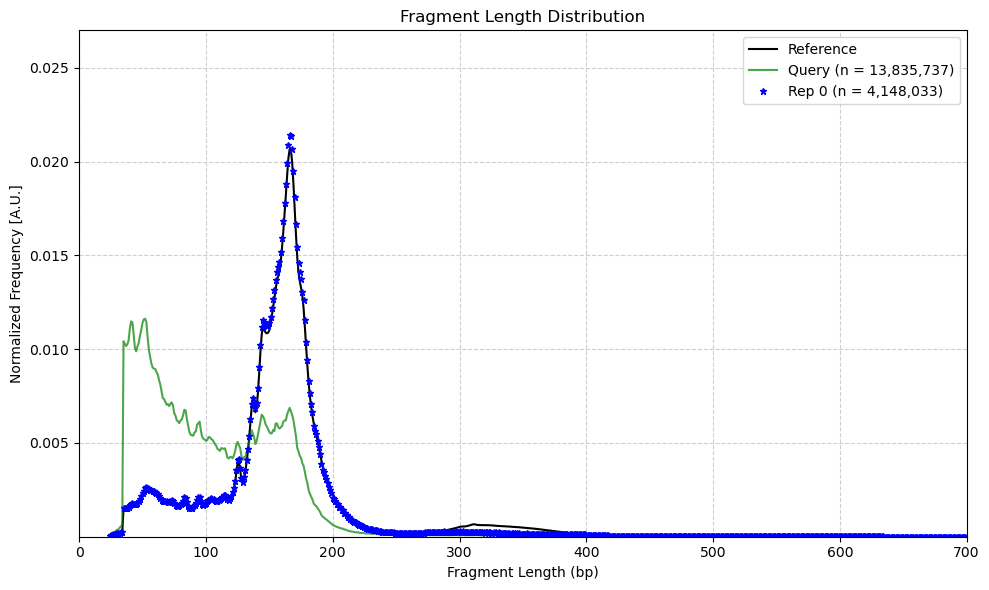

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import gzip
import numpy as np
import random

file_path = "query.bed.gz"
start_positions = []
end_positions = []

with gzip.open(file_path, 'rt') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 3:
            start = int(parts[1])
            end = int(parts[2])
            start_positions.append(start)
            end_positions.append(end)

fragment_lengths = [end - start for start, end in zip(start_positions, end_positions)]
length_counts = Counter(fragment_lengths)
total_fragments = sum(length_counts.values())
normalized_freq = {length: count / total_fragments for length, count in length_counts.items()}
sorted_lengths = sorted(normalized_freq.items())
x_vals = [length for length, freq in sorted_lengths]
y_vals = [freq for length, freq in sorted_lengths]

ref_df = pd.read_csv("reference.hist", sep=r'\s+', header=None, names=["length", "count"])
ref_total = ref_df["count"].sum()
ref_df["frequency"] = ref_df["count"] / ref_total
ref_hist = dict(zip(ref_df["length"], ref_df["frequency"]))

# Rescale query to match reference
target_total = 4295020 
length_to_fragments = defaultdict(list)
for idx, length in enumerate(fragment_lengths):
    length_to_fragments[length].append(idx)

target_counts = {length: int(freq * target_total) for length, freq in ref_hist.items()}

resampled_indices = []
for length, count in target_counts.items():
    candidates = length_to_fragments.get(length, [])
    if len(candidates) >= count:
        sampled = random.sample(candidates, count)
    else:
        sampled = candidates
    resampled_indices.extend(sampled)

resampled_lengths = [fragment_lengths[i] for i in resampled_indices]
resampled_counts = Counter(resampled_lengths)
resampled_total = sum(resampled_counts.values())
resampled_freq = {length: count/resampled_total for length, count in resampled_counts.items()}

plt.figure(figsize=(10, 6))

# Plot reference (solid line)
ref_x = sorted(ref_hist.keys())
ref_y = [ref_hist[x] for x in ref_x]
plt.plot(ref_x, ref_y, label='Reference', color='black', linewidth=1.5)

# Plot original query (solid line)
plt.plot(x_vals, y_vals, label=f'Query (n = {len(fragment_lengths):,})', 
         color='green', linewidth=1.5, alpha=0.7)

# Plot rescaled query (marker='*')
resampled_x = sorted(resampled_freq.keys())
resampled_y = [resampled_freq[x] for x in resampled_x]
plt.plot(resampled_x, resampled_y, label=f'Rep 0 (n = {resampled_total:,})', 
         color='blue', linestyle='None', marker='*', markersize=5)

plt.xlabel('Fragment Length (bp)')
plt.ylabel('Normalized Frequency [A.U.]')
plt.title('Fragment Length Distribution')

plt.ylim(0, 0.027) 
plt.xlim(0, 700)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')

plt.yticks([0.005, 0.01, 0.015, 0.02, 0.025])
plt.xticks(range(0, 701, 100))

plt.tight_layout()
plt.show()